# explorations into a dummy model

### dummy performance input

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
# time input
stamps = pd.date_range('2021-01-01','2021-03-01',freq='D')
dates = [i.strftime("%Y-%m-%d") for i in stamps]

In [3]:
# simulating turnover
n = len(np.array(dates))
x = np.arange(-n/2,n/2,1,dtype=np.float64)
m = np.random.uniform(0.35,0.4,(n,))
b = np.random.uniform(5,10,(n,))
turnover = x * m + b

# simulating mkt expenses
x = np.arange(-n/2,n/2,1,dtype=np.float64)
m = np.random.uniform(0.1,0.4,(n,))
b = np.random.uniform(1,2,(n,))
mkt_cost = x * m + b

In [4]:
# load data into pandas dataframe
df = pd.DataFrame()
df['date'] = dates
df['turnover'] = turnover
df['mkt_cost'] = mkt_cost

<AxesSubplot:>

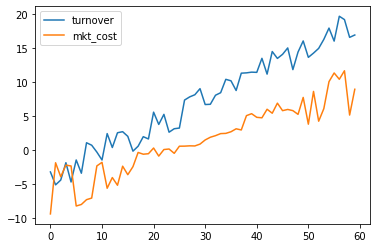

In [5]:
# visual inspection
df.plot()

### naive prediction on future performance

Reference to facebook prophet: https://facebook.github.io/prophet/docs/quick_start.html

In [9]:
from fbprophet import Prophet

# prepare data
data = df[['date','turnover']]
data.columns = ['ds','y']

# make a prediction with Prophet
m = Prophet()
m.fit(data)
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)
#forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


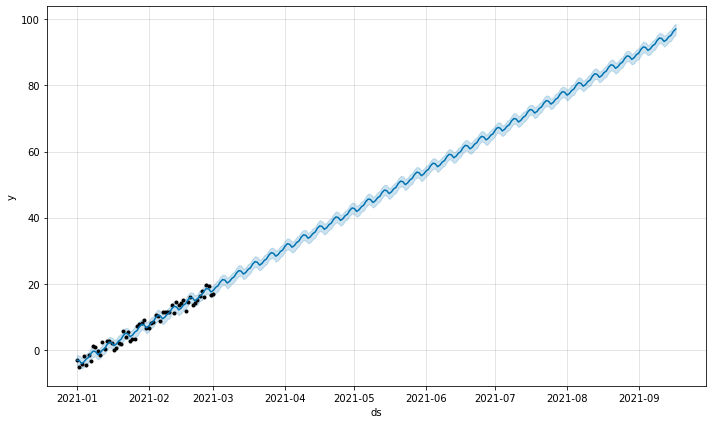

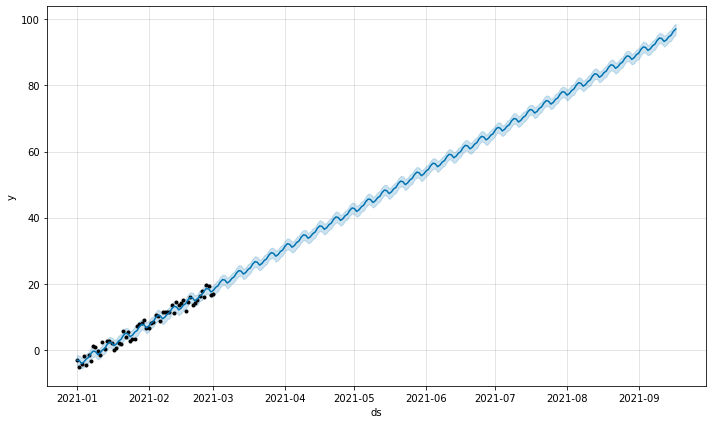

In [10]:
m.plot(forecast)

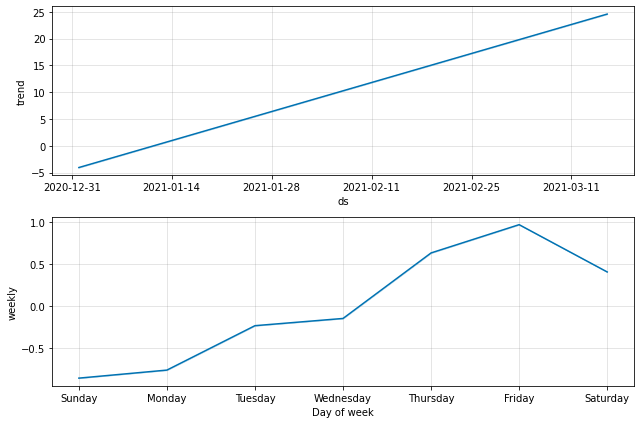

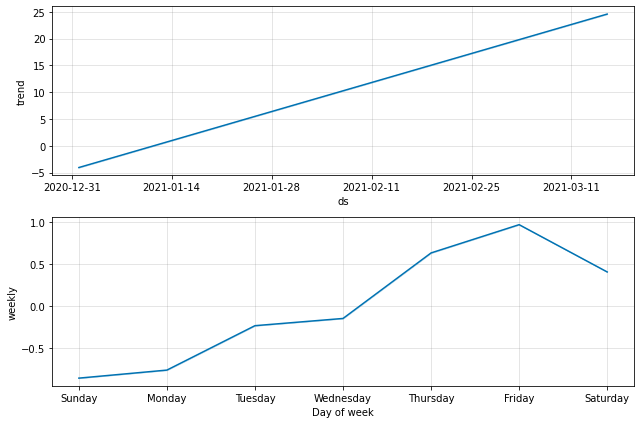

In [8]:
m.plot_components(forecast)

### target group input

In [14]:
# geography input
filepath = "../data/processed/gv100ad.csv"
geo = pd.read_csv(filepath)

# explore dataset for larger area around Aschaffenburg
geo.loc[(geo.rb == "Reg.-Bez. Darmstadt") | (geo.rb == "Unterfranken")].groupby("kreis").agg(
    {
        'gemeindename': 'count',
        'bev_geseamt': 'sum',
        'bev_maennl': 'sum',
        'bev_weibl': 'sum',
    }
).sort_values("bev_geseamt", ascending=False).head(20)

,gemeindename,bev_geseamt,bev_maennl,bev_weibl
kreis,,,,
"Frankfurt am Main, Stadt",1,763380,376802,386578
Main-Kinzig-Kreis,30,420552,207433,213119
Offenbach,13,355813,175379,180434
Wetteraukreis,25,308339,152469,155870
Darmstadt-Dieburg,23,297844,148046,149798
Würzburg,56,290236,141863,148373
"Wiesbaden, Landeshauptstadt",1,278474,133104,145370
Groß-Gerau,14,275726,138083,137643
Bergstraße,23,270340,133608,136732


In [20]:
# make a selection for targeted area
selected_districts = ['Aschaffenburg','Offenbach','Miltenberg','Darmstadt-Dieburg','Würzburg']
target_market = geo.loc[geo['kreis'].isin(selected_districts)]

population = target_market['bev_geseamt'].sum()
communities = target_market['gemeindename'].unique()

print(f"Wow! Dein Zielmarkt hat eine Gesamtpopulation von {population} Einwohnern verteilt auf {len(communities)} Gemeinden.")

Wow! Dein Zielmarkt hat eine Gesamtpopulation von 1317838 Einwohnern verteilt auf 167 Gemeinden.


In [21]:
# set a target selection for the total population of your market
target_share = 0.05
target_market['target_pop'] = target_market["bev_geseamt"] * target_share
target_pop = target_market['target_pop'].sum()

print(f"{int(target_share*100)}% aller Personen fallen in deine Zielgruppe. Das sind immer noch {int(target_pop)} potentielle Zielkunden. Amazing!")

5% aller Personen fallen in deine Zielgruppe. Das sind immer noch 65891 potentielle Zielkunden. Amazing!


In [22]:
# explore top communities
target_market.groupby(['kreis','vb']).agg(
    {
        'gemeindename': 'count',
        'bev_geseamt': 'sum',
        'bev_maennl': 'sum',
        'bev_weibl': 'sum',
        'target_pop': 'sum',
    }
).sort_values("bev_geseamt", ascending=False).head(5)

gemeindename  bev_geseamt  \
kreis             vb                                                      
Würzburg          Würzburg                               1       127934   
Aschaffenburg     Aschaffenburg                          1        71002   
Offenbach         Rodgau, Stadt                          1        45719   
                  Dreieich, Stadt                        1        42102   
                  Langen (Hessen), Stadt                 1        38229   
                  Neu-Isenburg, Stadt                    1        38105   
                  Dietzenbach, Kreisstadt                1        34298   
                  Mühlheim am Main, Stadt                1        28652   
                  Rödermark, Stadt                       1        28249   
Darmstadt-Dieburg Griesheim, Stadt                       1        27473   
                  Weiterstadt, Stadt                     1        26052   
                  Pfungstadt, Stadt                      1        25096   
Offenbach         Obertshausen, Stadt                    1        24982   
                  Seligenstadt, Einhardstadt             1        21267   
Darmstadt-Dieburg Groß-Umstadt, Stadt                    1        21251   
Offenbach         Heusenstamm, Stadt                     1        18956   
Aschaffenburg     Alzenau, St                            1        18505   
Darmstadt-Dieburg Babenhausen, Stadt                     1        16940   
                  Seeheim-Jugenheim                      1        16462   
                  Reinheim, Stadt                        1        16416   
Aschaffenburg     Großostheim, M                         1        16365   
Darmstadt-Dieburg Dieburg, Stadt                         1        15566   
                  Ober-Ramstadt, Stadt                   1        15166   
                  Münster (Hessen)                       1        14689   
                  Groß-Zimmern                           1        14622   
Offenbach         Hainburg                               1        14401   
Aschaffenburg     Schöllkrippen (VGem)                   7        13901   
Darmstadt-Dieburg Mühltal                                1        13844   
Aschaffenburg     Hösbach, M                             1        13240   
Darmstadt-Dieburg Roßdorf                                1        12612   
Offenbach         Egelsbach                              1        11489   
Aschaffenburg     Mömbris, M                             1        11487   
Würzburg          Ochsenfurt, St                         1        11296   
Miltenberg        Erlenbach a.Main, St                   1        10258   
Aschaffenburg     Goldbach, M                            1        10010   
Würzburg          Veitshöchheim                          1         9525   
                  Höchberg, M                            1         9503   
Offenbach         Mainhausen                             1         9364   
Miltenberg        Miltenberg, St                         1         9304   
Darmstadt-Dieburg Schaafheim                             1         9237   
Miltenberg        Elsenfeld, M                           1         9138   
Darmstadt-Dieburg Alsbach-Hähnlein                       1         9089   
Aschaffenburg     Mainaschaff                            1         8936   
Miltenberg        Obernburg a.Main, St                   1         8659   
Aschaffenburg     Haibach                                1         8461   
                  Kleinostheim                           1         8206   
                  Karlstein a.Main                       1         8087   
Darmstadt-Dieburg Erzhausen                              1         8070   
Aschaffenburg     Kahl a.Main                            1         8033   
                  Stockstadt a.Main, M                   1         8002   

                                              bev_maennl  bev_weibl  \
kreis             vb                                                  
Wür

In [23]:
# validity check with home community
home_community = ["Rottendorf"]
target_valid = target_market[target_market['gemeindename'].isin(home_community)]['target_pop'].sum()
pop_valid = target_market[target_market['gemeindename'].isin(home_community)]['bev_geseamt'].sum()

print(f"{len(home_community)} Validierungsgemeinde(n) in der Auswahl: {', '.join(home_community)}.")
print(f"> Hier gibt es eine Gesamtbevolkerung von {int(pop_valid)} Personen (Angabe von stat. Bundesamt, Dez. 2019).")
print(f"> Grundlage deiner Angaben ({int(target_share*100)}%-Zielkundenanteil), schätzen wir eine Anzahl von etwa {int(target_valid)} Personen als Zielkunden.")
print("\nAchtung!1!! Jetzt wieder aufwachen. Preisfrage:")
print(f"> Kannst du dir vorstellen, dass {int(target_valid)} Personen in deiner Hood dein Zeug kaufen wollen?")
print("> Wenn deine Antwort 'Nein' lauten sollte, dann sitz dir halt net den ganzen Tag den Arsch platt sondern änder bitte was an deinen Annahmen.")

1 Validierungsgemeinde(n) in der Auswahl: Rottendorf.
> Hier gibt es eine Gesamtbevolkerung von 5340 Personen (Angabe von stat. Bundesamt, Dez. 2019).
> Grundlage deiner Angaben(5%-Zielkundenanteil), schätzen wir eine Anzahl von etwa 267 Personen als Zielkunden.

Achtung!1!! Jetzt wieder aufwachen. Preisfrage:
> Kannst du dir vorstellen, dass 267 Personen in deiner Hood dein Zeug kaufen wollen?
> Wenn deine Antwort 'Nein' lauten sollte, dann sitz dir halt net den ganzen Tag den Arsch platt sondern änder bitte was an deinen Annahmen.
